# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [3]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("data/returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

rets.head()

USA_EWJ   USA_EWT  USA_MCHI   USA_EWY   USA_EWZ  USA_INDA  \
Date                                                                     
2011-01-04  0.000804 -0.007407       NaN  0.002263  0.004396       NaN   
2011-01-05 -0.007231 -0.016584       NaN  0.000376 -0.011616       NaN   
2011-01-06  0.000000 -0.002108       NaN -0.006960 -0.010049       NaN   
2011-01-07  0.003777 -0.015632       NaN  0.005493 -0.009119       NaN   
2011-01-10  0.000000  0.002146       NaN -0.014883 -0.010071       NaN   

            USA_ACWV   USA_IDV   USA_EWC   USA_EWU  ...  CAN_HULC.TO  \
Date                                                ...                
2011-01-04       NaN -0.009259 -0.010412  0.010462  ...          NaN   
2011-01-05       NaN -0.002596  0.002023 -0.002157  ...          NaN   
2011-01-06       NaN -0.009891 -0.004847 -0.008647  ...          NaN   
2011-01-07       NaN -0.005258  0.000406 -0.003925  ...          NaN   
2011-01-10       NaN  0.000529 -0.003651  0.001751  ...          NaN   

            CAN_HMUS.TO  CAN_HSUV.TO  USA_CNY=X  USA_BRL=X  USA_ZAR=X  \
Date                                                                    
2011-01-04          NaN          NaN  -0.001760   0.019189   0.006326   
2011-01-05          NaN          NaN   0.002584   0.012754   0.003853   
2011-01-06          NaN          NaN  -0.002956   0.004498   0.008670   
2011-01-07          NaN          NaN   0.005929   0.006507   0.012983   
2011-01-10          NaN          NaN   0.000151  -0.029895  -0.000295   

            USA_RUB=X  USA_EUR=X  USA_JPY=X  USA_MXN=X  
Date                                                    
2011-01-04        0.0   0.000134   0.006743  -0.000384  
2011-01-05        0.0   0.002671   0.004506  -0.004249  
2011-01-06        0.0   0.012522   0.014030   0.003119  
2011-01-07        0.0   0.013551   0.001334   0.000573  
2011-01-10        0.0   0.006620  -0.003241  -0.001063  

[5 rows x 128 columns]

In [4]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [5]:
sum(rets["USA_RUB=X"] > 100)

0

In [6]:
# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = (1 + riskfree).pow(1/252) - 1

riskfree.head()

RFR
Date                
2011-01-04  0.000520
2011-01-05  0.000520
2011-01-06  0.000537
2011-01-07  0.000520
2011-01-10  0.000520

In [7]:
len(riskfree.index) == len(rets.index)

True

In [349]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("data/benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')

# calculate excess returns
rf_bm = riskfree[riskfree.index.isin(benchmark.index.values)]
benchmark_ret = benchmark['return']
benchmark_excess = benchmark['return'].subtract(rf_bm['RFR'], axis=0)

In [350]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31',
               ...
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30'],
              dtype='datetime64[ns]', length=126, freq='M')

In [351]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [352]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])
print(semiannual[1].index[0],semiannual[1].index[-1])
print(semiannual[19].index[0],semiannual[19].index[-1])

2011-01-31 00:00:00 2011-02-28 00:00:00
2011-02-28 00:00:00 2011-03-31 00:00:00
2012-08-31 00:00:00 2012-09-28 00:00:00


# Lowest correlation Search

In [353]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)

# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XIG.TO    0.121284
CAN_HUN.TO    0.128026
CAN_CVD.TO    0.141299
USA_EUR=X     0.156604
USA_ZAR=X     0.166535
USA_BRL=X     0.176512
CAN_XFR.TO    0.180241
USA_JPY=X     0.190934
CAN_CMR.TO    0.211174
USA_RUB=X     0.230144
CAN_CBO.TO    0.249043
CAN_HUC.TO    0.273630
CAN_CLF.TO    0.274188
USA_ACWV      0.307169
USA_CNY=X     0.316464
CAN_XPF.TO    0.386142
CAN_CHB.TO    0.458711
CAN_HUG.TO    0.507996
CAN_CGR.TO    0.538380
CAN_HUZ.TO    0.550698
CAN_CGL.TO    0.561401
USA_ERUS      0.573046
USA_MXN=X     0.573206
USA_EWT       0.579409
CAN_SVR.TO    0.580247
USA_EIS       0.583671
CAN_DLR.TO    0.589748
CAN_HXS.TO    0.612754
CAN_XHY.TO    0.631969
CAN_XGD.TO    0.633477
dtype: float64

In [354]:
semiannual[4].cumsum()

USA_EWJ   USA_EWT  USA_MCHI   USA_EWY   USA_EWZ  USA_INDA  \
Date                                                                     
2011-05-31  0.017841  0.029163  0.022090  0.017238  0.011727       NaN   
2011-06-01  0.005198  0.027931  0.007682  0.001175 -0.009172       NaN   
2011-06-02  0.006071  0.032454  0.010983  0.004225  0.004460       NaN   
2011-06-03 -0.002653  0.028770 -0.005938 -0.000962  0.007822       NaN   
2011-06-06 -0.012626  0.023429 -0.012632 -0.012469 -0.016340       NaN   
2011-06-07 -0.004626  0.031690 -0.006615 -0.007376 -0.013267       NaN   
2011-06-08 -0.005508  0.024726 -0.022644 -0.020948 -0.017412       NaN   
2011-06-09  0.001259  0.032564 -0.016566 -0.014894 -0.012165       NaN   
2011-06-10 -0.008385  0.002273 -0.038557 -0.044435 -0.028903       NaN   
2011-06-13 -0.008385 -0.010812 -0.045229 -0.039737 -0.032381       NaN   
2011-06-14  0.011385  0.006296 -0.031050 -0.014490 -0.021727       NaN   
2011-06-15 -0.008002 -0.012627 -0.050181 -0.035285 -0.038630       NaN   
2011-06-16 -0.011247 -0.023343 -0.054182 -0.044041 -0.051017       NaN   
2011-06-17 -0.007991 -0.024643 -0.055438 -0.045356 -0.046524       NaN   
2011-06-20 -0.007106 -0.031150 -0.056946 -0.051190 -0.041306       NaN   
2011-06-21  0.009993 -0.016303 -0.038064 -0.026583 -0.034632       NaN   
2011-06-22  0.008544 -0.025770 -0.046959 -0.031386 -0.033159       NaN   
2011-06-23  0.006802 -0.029679 -0.059674 -0.033799 -0.046215       NaN   
2011-06-24  0.012618 -0.045815 -0.036947 -0.030263 -0.049942       NaN   
2011-06-27  0.007703 -0.038280 -0.019663 -0.023959 -0.037598       NaN   
2011-06-28  0.019615 -0.034320 -0.015294 -0.013640 -0.011365       NaN   
2011-06-29  0.035406 -0.021174 -0.014086 -0.001603 -0.003444       NaN   
2011-06-30  0.043037 -0.006901 -0.004431  0.009030  0.003521       NaN   

            USA_ACWV   USA_IDV   USA_EWC   USA_EWU  ...  CAN_HULC.TO  \
Date                                                ...                
2011-05-31       NaN  0.013258  0.009601  0.011457  ...          NaN   
2011-06-01       NaN -0.009640 -0.018547 -0.016051  ...          NaN   
2011-06-02       NaN -0.001031 -0.019330 -0.014388  ...          NaN   
2011-06-03       NaN -0.001505 -0.022463 -0.011896  ...          NaN   
2011-06-06       NaN -0.015263 -0.038966 -0.020181  ...          NaN   
2011-06-07       NaN -0.003719 -0.037768 -0.011409  ...          NaN   
2011-06-08       NaN -0.016557 -0.046547 -0.022589  ...          NaN   
2011-06-09       NaN -0.004997 -0.036482 -0.010864  ...          NaN   
2011-06-10       NaN -0.030235 -0.054019 -0.038596  ...          NaN   
2011-06-13       NaN -0.026815 -0.058482 -0.033061  ...          NaN   
2011-06-14       NaN -0.007828 -0.040144 -0.022054  ...          NaN   
2011-06-15       NaN -0.041750 -0.060552 -0.050111  ...          NaN   
2011-06-16       NaN -0.044718 -0.071582 -0.060020  ...          NaN   
2011-06-17       NaN -0.032317 -0.073234 -0.051752  ...          NaN   
2011-06-20       NaN -0.035257 -0.070338 -0.050026  ...          NaN   
2011-06-21       NaN -0.019532 -0.046823 -0.031930  ...          NaN   
2011-06-22       NaN -0.029208 -0.048838 -0.045895  ...          NaN   
2011-06-23       NaN -0.038490 -0.060147 -0.057054  ...          NaN   
2011-06-24       NaN -0.051803 -0.074036 -0.064433  ...          NaN   
2011-06-27       NaN -0.043307 -0.069065 -0.056999  ...          NaN   
2011-06-28       NaN -0.034883 -0.052164 -0.046149  ...          NaN   
2011-06-29       NaN -0.019158 -0.033113 -0.030691  ...          NaN   
2011-06-30       NaN  0.000677 -0.019589 -0.015892  ...          NaN   

            CAN_HMUS.TO  CAN_HSUV.TO  USA_CNY=X  USA_BRL=X  USA_ZAR=X  \
Date                                                                    
2011-05-31          NaN          NaN  -0.001142  -0.000815   0.003886   
2011-06-01          NaN          NaN  -0.000339  -0.009792  -0.013980   
2011-06-02          NaN          NaN  -0.000493  -0.001368  -0.012568

In [355]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

In [356]:
corrs = ((1+semiannual[5]).cumprod()-1).iloc[-1]
a = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
a

['USA_EWI',
 'USA_EWQ',
 'USA_ECH',
 'USA_TUR',
 'USA_EWP',
 'USA_EWO',
 'USA_EIRL',
 'USA_EWK',
 'USA_EPOL',
 'USA_JPY=X']

In [357]:
top10 = {}
for i in range(1,len(semiannual)):
    corrs =  ((1+semiannual[i-1]).cumprod()-1).iloc[-1]
    
    top10[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = ((1+semiannual[i-1]).cumprod()-1).iloc[-1]
    
    top15[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = ((1+semiannual[i-1]).cumprod()-1).iloc[-1]
    
    top30[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:30]

# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [358]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer

from importlib import reload
reload(portfolio_optimizer)

from portfolio_optimizer import portfolio_optimizer

In [359]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':5000,'VaR99':5800,'CVaR95':5700,'CVaR99':5400}

10 cutoff ETFs

In [360]:
opt10 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Equally weighted')

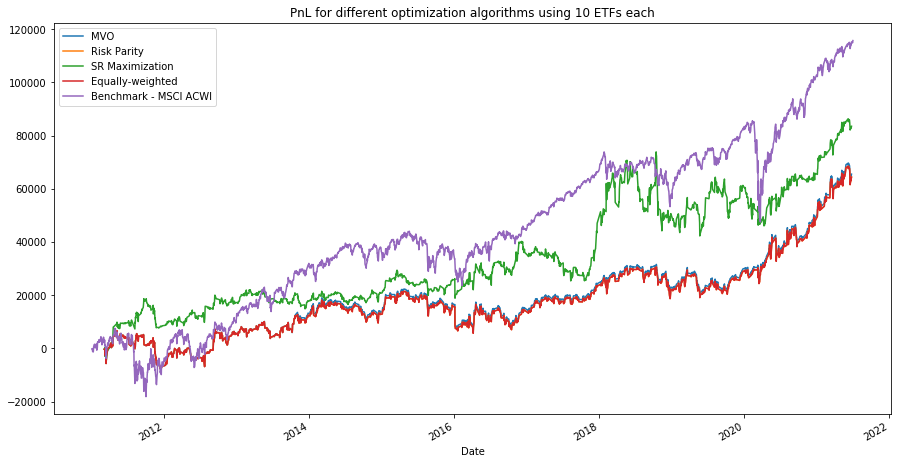

In [361]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
((benchmark_ret*100000).cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI'))

plt.title('PnL for different optimization algorithms using 10 ETFs each')
plt.legend()
plt.show()

In [362]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -215.32260804998566%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -2014.196077 -2324.152237 -2169.174157 -2324.152237
2       -908.669736 -1602.876398 -1255.773067 -1602.876398
3      -2335.380841 -3873.699654 -3104.540247 -3873.699654
4       -903.723572 -1048.889918  -976.306745 -1048.889918
5      -1181.430393 -1900.747942 -1541.089167 -1900.747942
...             ...          ...          ...          ...
120    -2197.117354 -2197.117354 -2197.117354 -2197.117354
121    -2926.490928 -3753.454970 -3339.972949 -3753.454970
122    -1306.469601 -2049.118034 -1677.793818 -2049.118034
123    -2267.161955 -3287.827267 -2777.494611 -3287.827267
124    -1716.339501 -3257.561376 -2486.950438 -3257.561376

[124 rows x 4 columns]

In [363]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -215.32211124086783%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -2014.195570 -2324.151826 -2169.173698 -2324.151826
2       -908.669463 -1602.874721 -1255.772092 -1602.874721
3      -2335.377930 -3873.695681 -3104.536806 -3873.695681
4       -903.722783 -1048.888169  -976.305476 -1048.888169
5      -1181.428843 -1900.745907 -1541.087375 -1900.745907
...             ...          ...          ...          ...
120    -2183.340670 -2183.340670 -2183.340670 -2183.340670
121    -2908.139014 -3729.919616 -3319.029315 -3729.919616
122    -1298.275742 -2036.267780 -1667.271761 -2036.267780
123    -2252.946682 -3267.213088 -2760.079885 -3267.213088
124    -1705.577750 -3237.136199 -2471.356974 -3237.136199

[124 rows x 4 columns]

In [364]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -2338.470470703189%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1908.034756 -3093.361530 -2500.698143 -3093.361530
2      -1166.072303 -2470.575025 -1818.323664 -2470.575025
3      -2152.881159 -2900.399129 -2526.640144 -2900.399129
4       -222.774852  -278.655007  -250.714930  -278.655007
5      -1167.070701 -1637.931477 -1402.501089 -1637.931477
...             ...          ...          ...          ...
120    -1810.782131 -1810.782131 -1810.782131 -1810.782131
121    -1849.767741 -2448.601296 -2149.184518 -2448.601296
122     -607.826499  -924.895646  -766.361072  -924.895646
123    -1637.619026 -2046.988694 -1842.303860 -2046.988694
124    -1223.441919 -1891.091076 -1557.266498 -1891.091076

[124 rows x 4 columns]

In [365]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -215.32260804998566%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -2014.196077 -2324.152237 -2169.174157 -2324.152237
2       -908.669736 -1602.876398 -1255.773067 -1602.876398
3      -2335.380841 -3873.699654 -3104.540247 -3873.699654
4       -903.723572 -1048.889918  -976.306745 -1048.889918
5      -1181.430393 -1900.747942 -1541.089167 -1900.747942
...             ...          ...          ...          ...
120    -2183.342066 -2183.342066 -2183.342066 -2183.342066
121    -2908.142680 -3729.921897 -3319.032288 -3729.921897
122    -1298.278416 -2036.270659 -1667.274538 -2036.270659
123    -2252.947508 -3267.213545 -2760.080526 -3267.213545
124    -1705.578550 -3237.137412 -2471.357981 -3237.137412

[124 rows x 4 columns]

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 10 ETFs each')

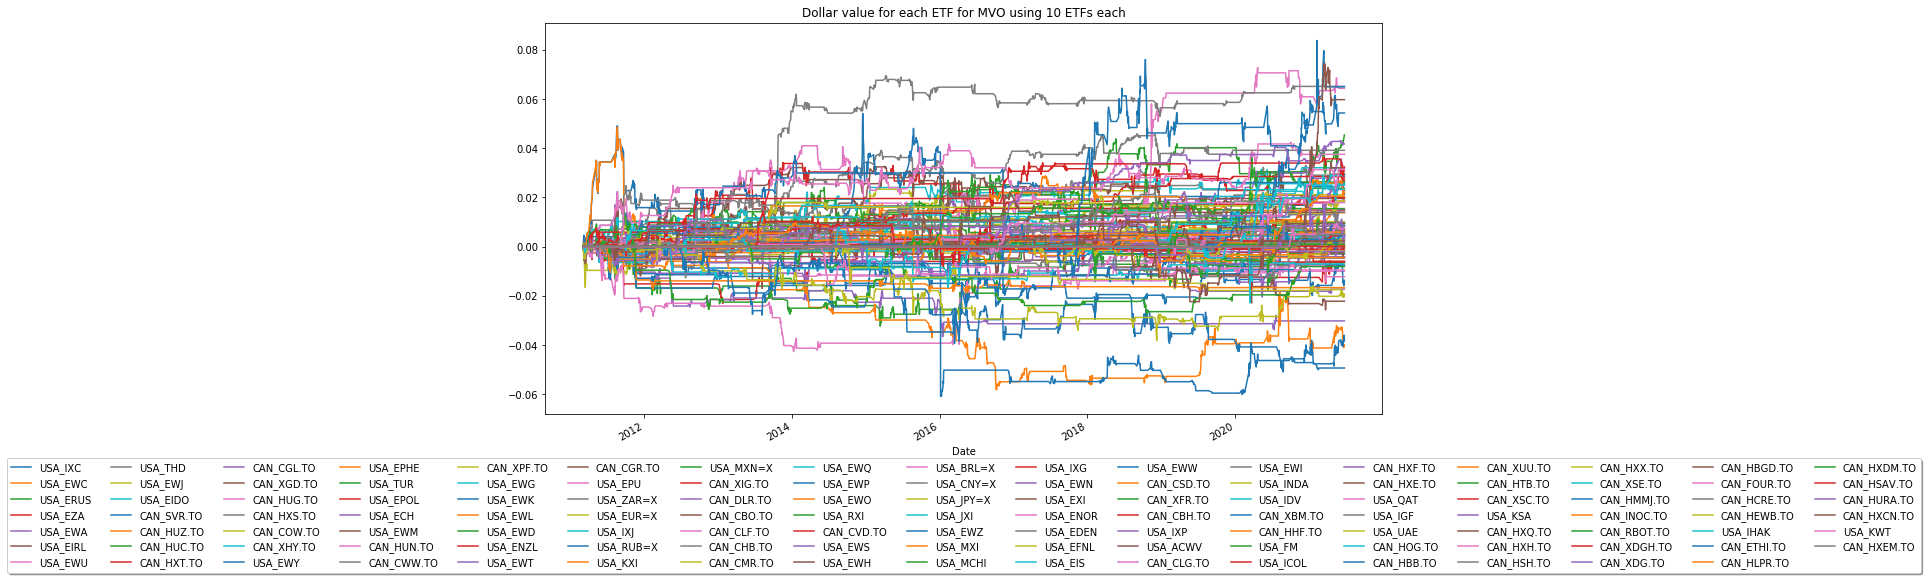

In [366]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/7))
plt.title('Dollar value for each ETF for MVO using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 10 ETFs each')

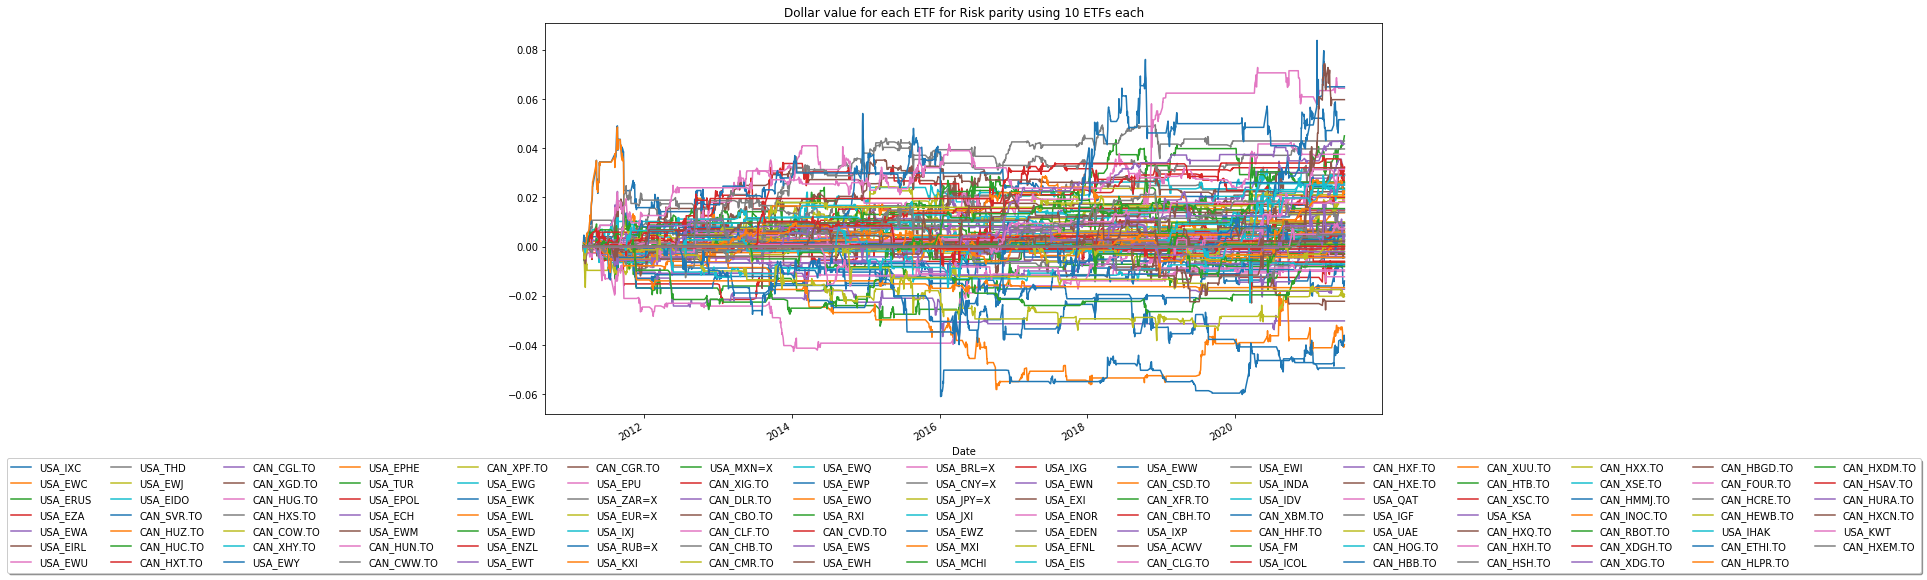

In [367]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/7))
plt.title('Dollar value for each ETF for Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 10 ETFs each')

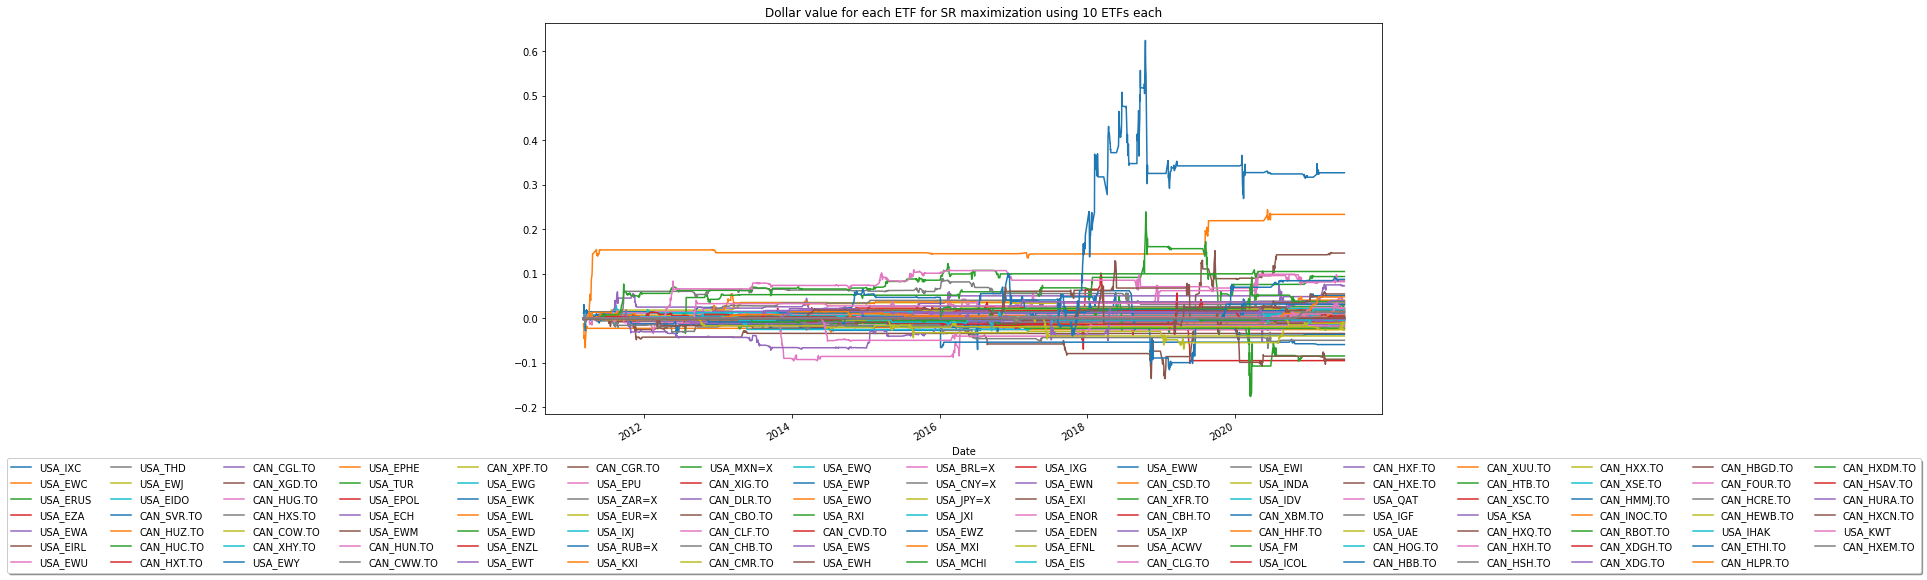

In [368]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/7))
plt.title('Dollar value for each ETF for SR maximization using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 10 ETFs each')

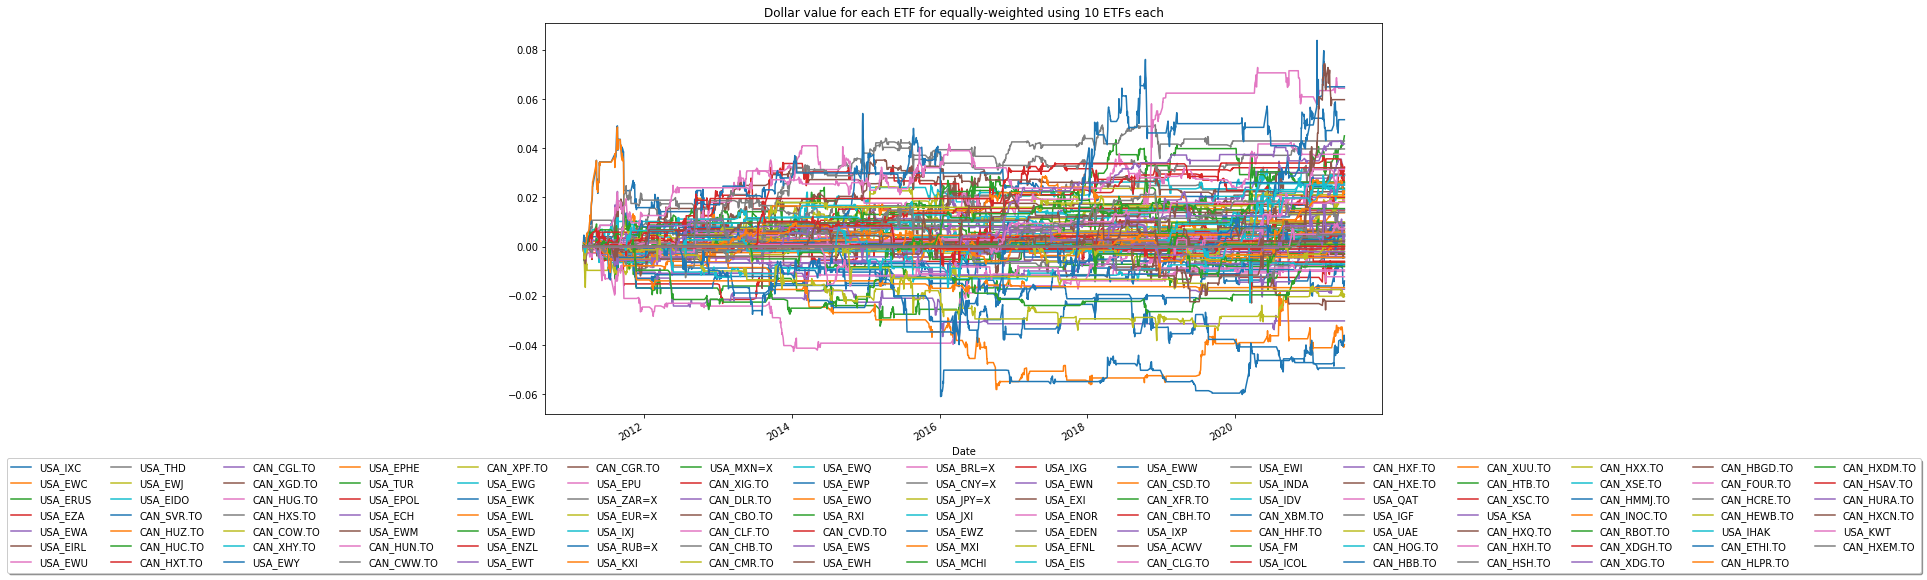

In [369]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 10 ETFs each')

15 cutoff ETFs

In [370]:
opt15 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Equally weighted')

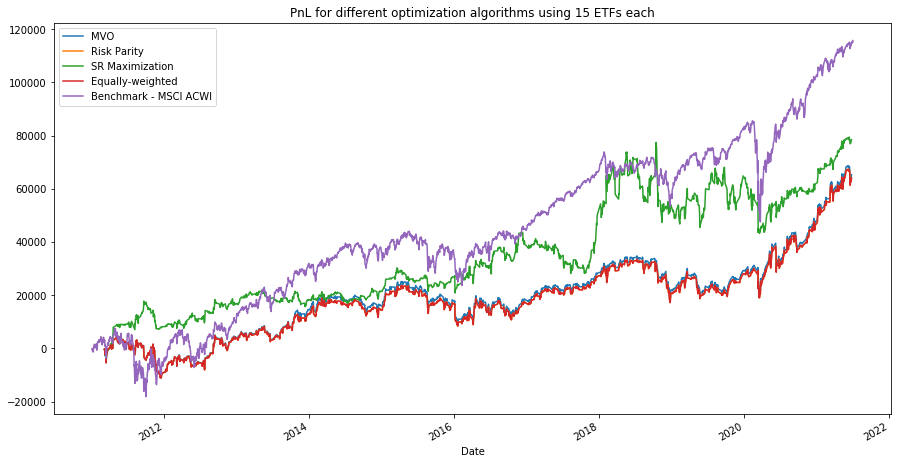

In [371]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
((benchmark_ret*100000).cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI'))

plt.title('PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

In [ ]:
PnL_sr.cumsum()

In [372]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -325.91819268539774%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1852.312062 -2063.091566 -1957.701814 -2063.091566
2       -830.639469 -1504.123325 -1167.381397 -1504.123325
3      -1777.677616 -2954.617320 -2366.147468 -2954.617320
4       -916.163132 -1014.090028  -965.126580 -1014.090028
5      -1082.307142 -1942.147796 -1512.227469 -1942.147796
...             ...          ...          ...          ...
120    -2400.179612 -2400.179612 -2400.179612 -2400.179612
121    -2569.466305 -2971.710339 -2770.588322 -2971.710339
122    -1490.821290 -2006.143968 -1748.482629 -2006.143968
123    -2104.621947 -2794.432715 -2449.527331 -2794.432715
124    -1610.934164 -2872.098116 -2241.516140 -2872.098116

[124 rows x 4 columns]

In [373]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -325.9169689434402%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1852.311520 -2063.090916 -1957.701218 -2063.090916
2       -830.638926 -1504.122271 -1167.380599 -1504.122271
3      -1777.675006 -2954.613406 -2366.144206 -2954.613406
4       -916.162305 -1014.088496  -965.125401 -1014.088496
5      -1082.305374 -1942.145636 -1512.225505 -1942.145636
...             ...          ...          ...          ...
120    -2386.125000 -2386.125000 -2386.125000 -2386.125000
121    -2554.406753 -2954.305467 -2754.356110 -2954.305467
122    -1482.090279 -1994.395800 -1738.243039 -1994.395800
123    -2092.299351 -2778.070910 -2435.185130 -2778.070910
124    -1601.502194 -2855.280690 -2228.391442 -2855.280690

[124 rows x 4 columns]

In [374]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -84.7585443643758%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1390.790837 -2268.898361 -1829.844599 -2268.898361
2      -1177.533231 -2494.346787 -1835.940009 -2494.346787
3       -754.406713 -1537.268093 -1145.837403 -1537.268093
4       -226.114214  -275.951798  -251.033006  -275.951798
5      -1173.029618 -1645.989041 -1409.509330 -1645.989041
...             ...          ...          ...          ...
120    -1856.499282 -1856.499282 -1856.499282 -1856.499282
121    -1209.853322 -1841.339621 -1525.596471 -1841.339621
122     -519.342850  -817.704101  -668.523476  -817.704101
123    -1313.307284 -1704.292780 -1508.800032 -1704.292780
124     -788.610970  -911.595114  -850.103042  -911.595114

[124 rows x 4 columns]

In [375]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -325.91819268539774%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1852.312062 -2063.091566 -1957.701814 -2063.091566
2       -830.639469 -1504.123325 -1167.381397 -1504.123325
3      -1777.677616 -2954.617320 -2366.147468 -2954.617320
4       -916.163132 -1014.090028  -965.126580 -1014.090028
5      -1082.307142 -1942.147796 -1512.227469 -1942.147796
...             ...          ...          ...          ...
120    -2386.127576 -2386.127576 -2386.127576 -2386.127576
121    -2554.423167 -2954.312233 -2754.367700 -2954.312233
122    -1482.093162 -1994.398844 -1738.246003 -1994.398844
123    -2092.300276 -2778.072494 -2435.186385 -2778.072494
124    -1601.502826 -2855.283196 -2228.393011 -2855.283196

[124 rows x 4 columns]

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 15 ETFs each')

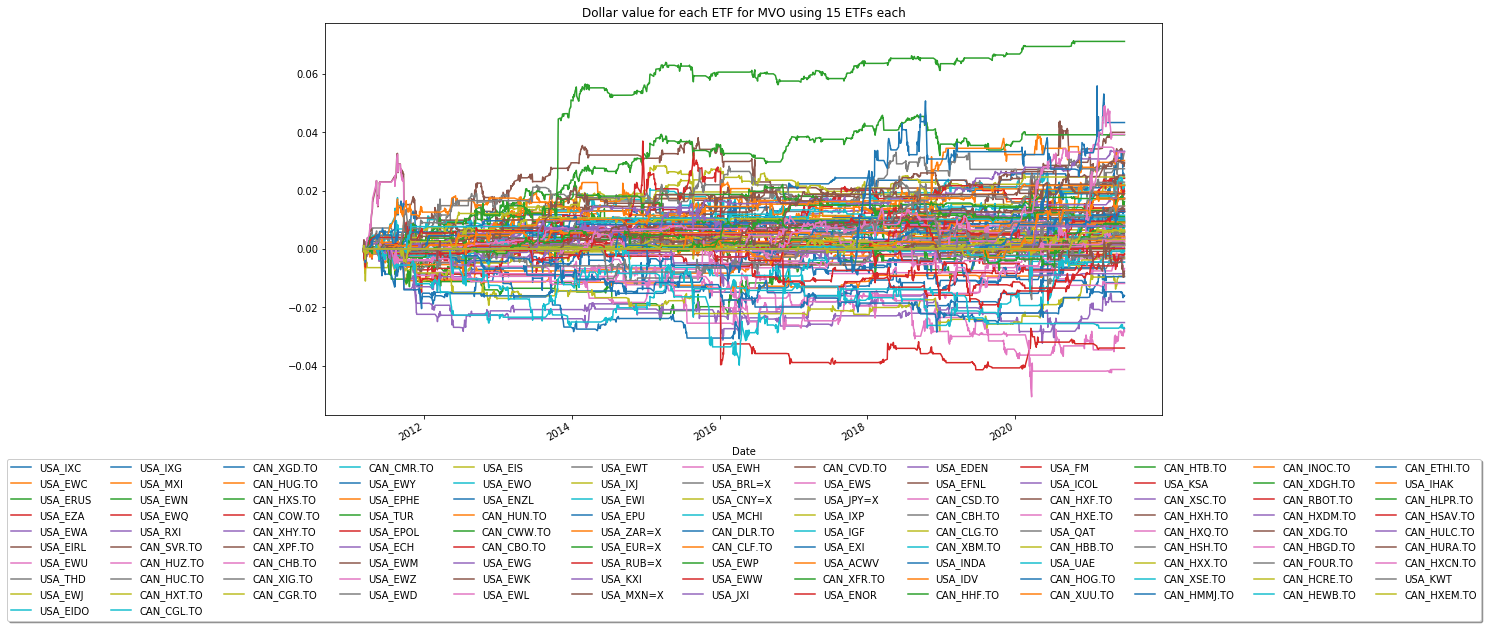

In [376]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/9))
plt.title('Dollar value for each ETF for MVO using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 15 ETFs each')

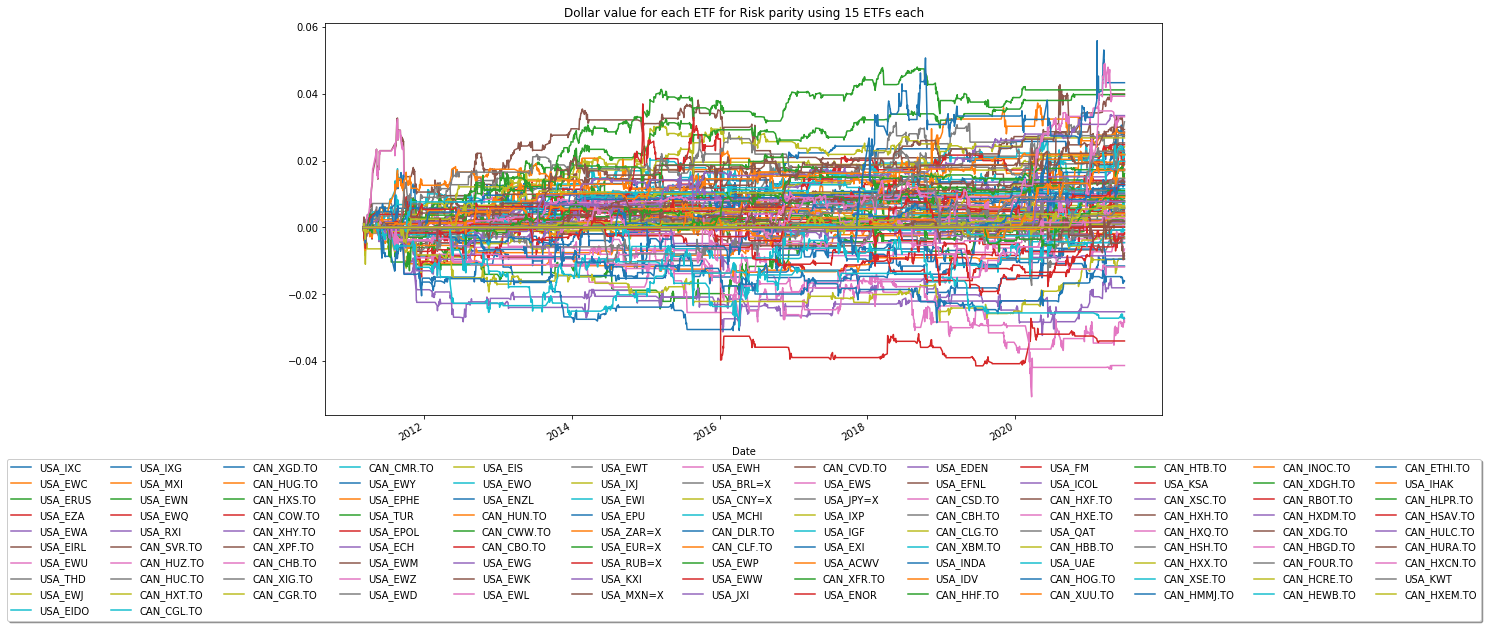

In [377]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/9))
plt.title('Dollar value for each ETF for Risk parity using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 15 ETFs each')

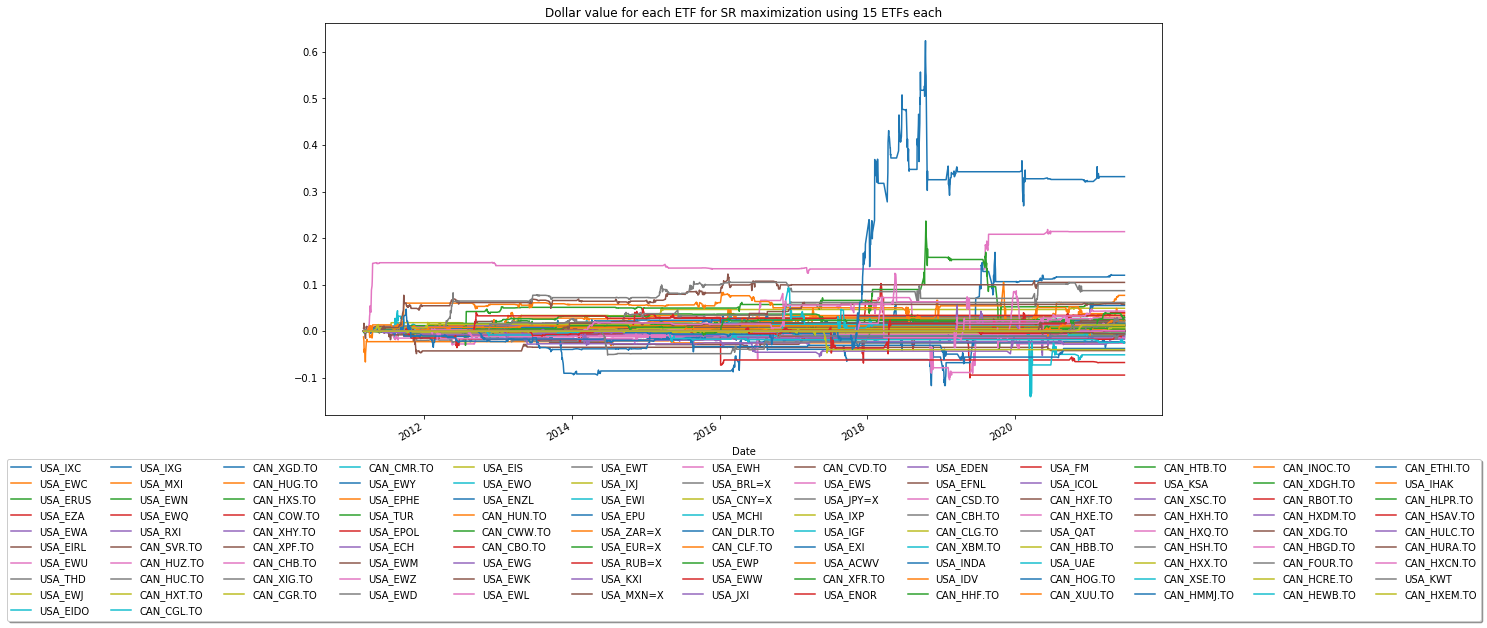

In [378]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/9))
plt.title('Dollar value for each ETF for SR maximization using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 15 ETFs each')

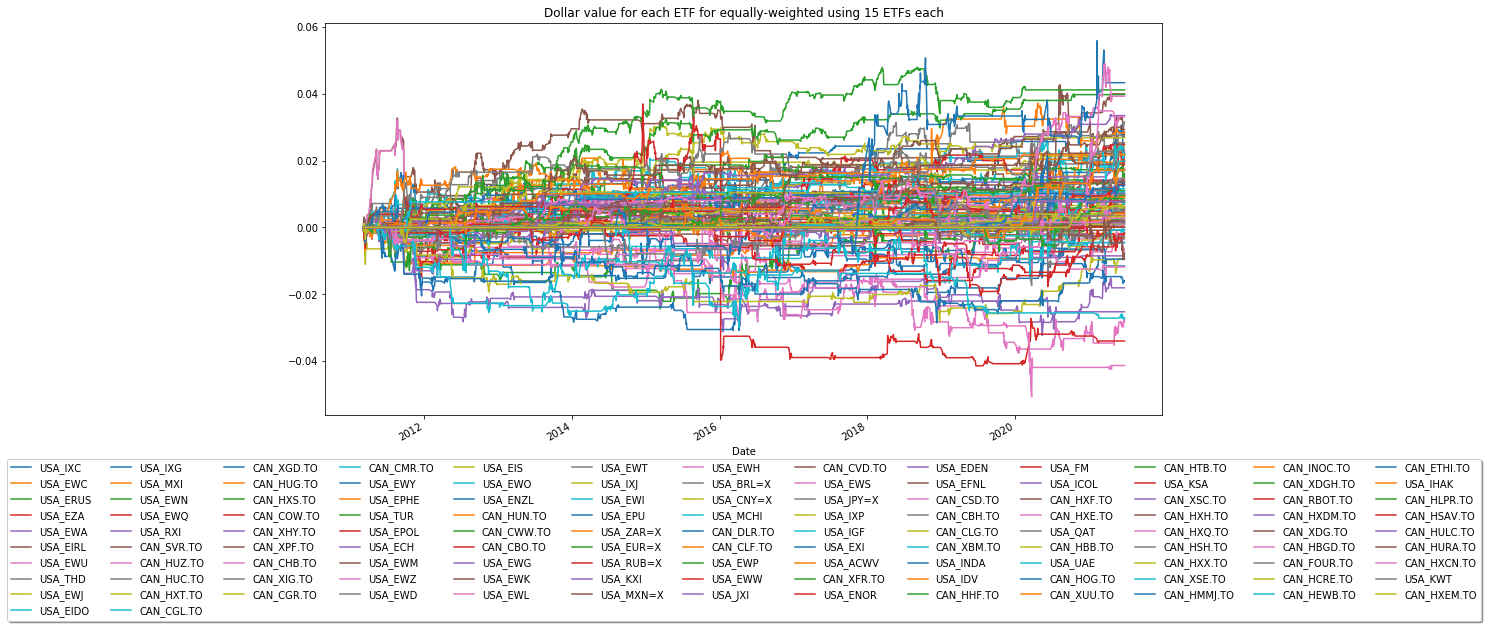

In [379]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/9))
plt.title('Dollar value for each ETF for equally-weighted using 15 ETFs each')

30 cutoff ETFs

In [380]:
opt30 = portfolio_optimizer(semiannual)

# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top30, 30, VaRcutoff, 'Equally weighted')

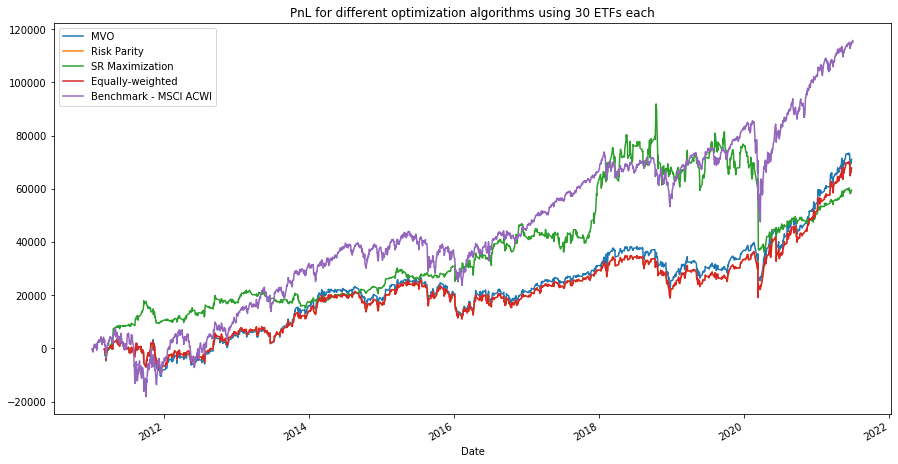

In [381]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
(benchmark_ret*100000).cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 30 ETFs each')
plt.legend()
plt.show()

In [382]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -392.5595051746958%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1456.568223 -1751.523411 -1604.045817 -1751.523411
2       -674.673599 -1249.697693  -962.185646 -1249.697693
3      -1345.307651 -2035.125323 -1690.216487 -2035.125323
4      -1031.049866 -1197.006839 -1114.028352 -1197.006839
5       -964.714397 -1541.232115 -1252.973256 -1541.232115
...             ...          ...          ...          ...
120    -2053.556095 -2053.556095 -2053.556095 -2053.556095
121    -2157.378051 -2447.190906 -2302.284478 -2447.190906
122    -1173.303419 -1534.235689 -1353.769554 -1534.235689
123    -1817.280246 -2605.165694 -2211.222970 -2605.165694
124    -1477.368659 -2437.348331 -1957.358495 -2437.348331

[124 rows x 4 columns]

In [383]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -353.34640890336095%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1456.567306 -1751.522232 -1604.044769 -1751.522232
2       -674.672800 -1249.696140  -962.184470 -1249.696140
3      -1345.305560 -2035.122157 -1690.213859 -2035.122157
4      -1031.045061 -1197.001432 -1114.023247 -1197.001432
5       -964.714149 -1541.226254 -1252.970202 -1541.226254
...             ...          ...          ...          ...
120    -2025.681751 -2025.681751 -2025.681751 -2025.681751
121    -2128.090900 -2413.964661 -2271.027781 -2413.964661
122    -1157.376561 -1513.409629 -1335.393095 -1513.409629
123    -1792.615499 -2569.807963 -2181.211731 -2569.807963
124    -1457.316746 -2404.266672 -1930.791709 -2404.266672

[124 rows x 4 columns]

In [384]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -90.85848478753087%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1383.525478 -2255.030048 -1819.277763 -2255.030048
2      -1151.034071 -2396.426480 -1773.730276 -2396.426480
3       -754.180927 -1455.016128 -1104.598527 -1455.016128
4       -226.473170  -274.060177  -250.266673  -274.060177
5       -461.641438 -1016.848966  -739.245202 -1016.848966
...             ...          ...          ...          ...
120    -1254.395001 -1254.395001 -1254.395001 -1254.395001
121     -745.254285  -988.139740  -866.697012  -988.139740
122     -359.164026  -478.395191  -418.779608  -478.395191
123     -787.047373 -1423.758987 -1105.403180 -1423.758987
124     -678.330655  -787.110397  -732.720526  -787.110397

[124 rows x 4 columns]

In [385]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -353.3494824272234%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1456.568223 -1751.523411 -1604.045817 -1751.523411
2       -674.673599 -1249.697693  -962.185646 -1249.697693
3      -1345.307651 -2035.125323 -1690.216487 -2035.125323
4      -1031.049866 -1197.006839 -1114.028352 -1197.006839
5       -964.714397 -1541.232115 -1252.973256 -1541.232115
...             ...          ...          ...          ...
120    -2025.689370 -2025.689370 -2025.689370 -2025.689370
121    -2128.102464 -2413.982562 -2271.042513 -2413.982562
122    -1157.381709 -1513.416134 -1335.398922 -1513.416134
123    -1792.619781 -2569.813635 -2181.216708 -2569.813635
124    -1457.320789 -2404.273551 -1930.797170 -2404.273551

[124 rows x 4 columns]

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 30 ETFs each')

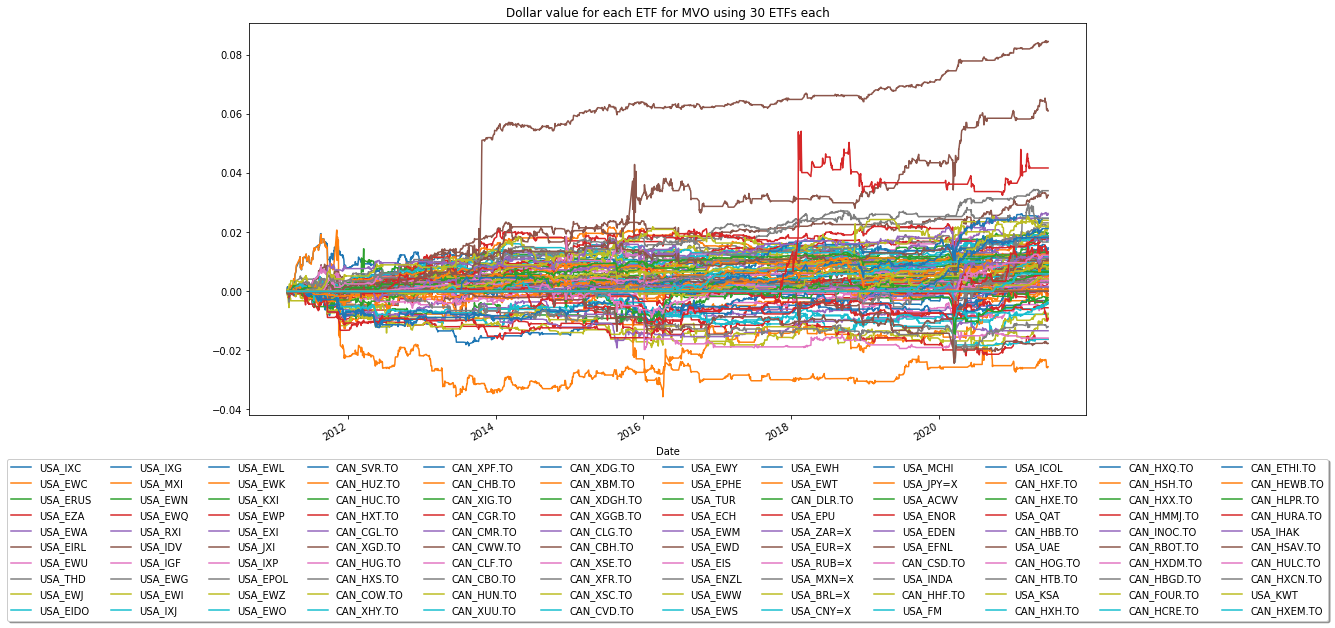

In [386]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/10))
plt.title('Dollar value for each ETF for MVO using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 30 ETFs each')

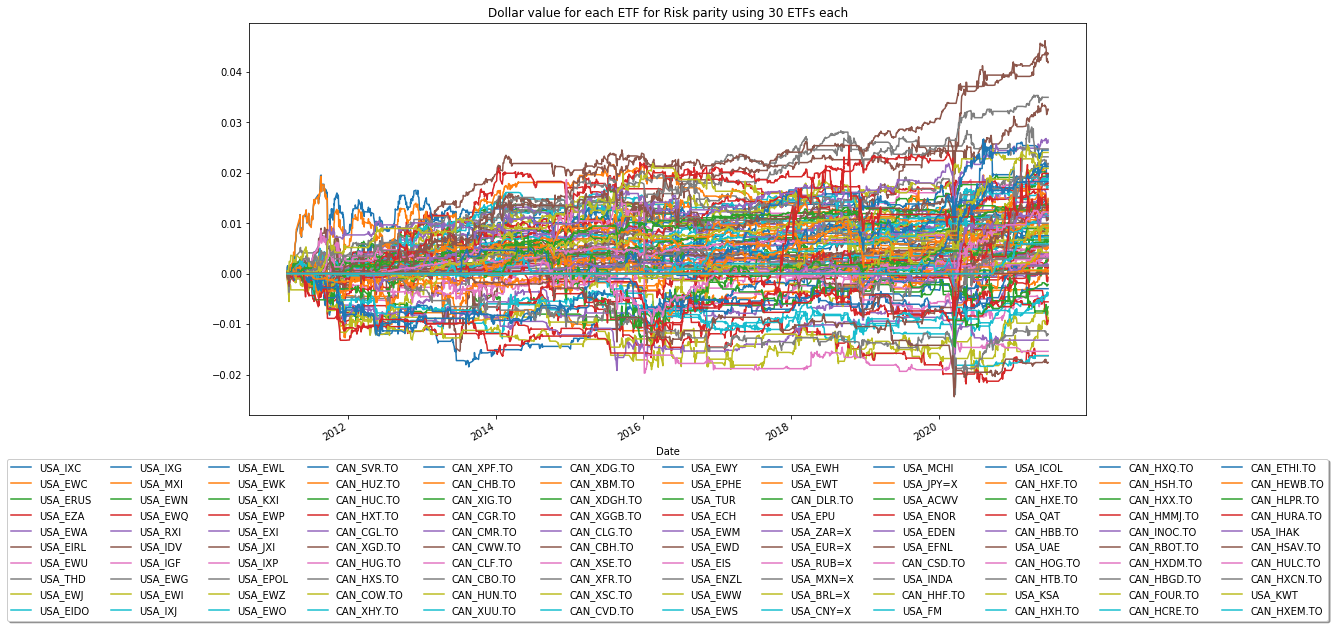

In [387]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/10))
plt.title('Dollar value for each ETF for Risk parity using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 30 ETFs each')

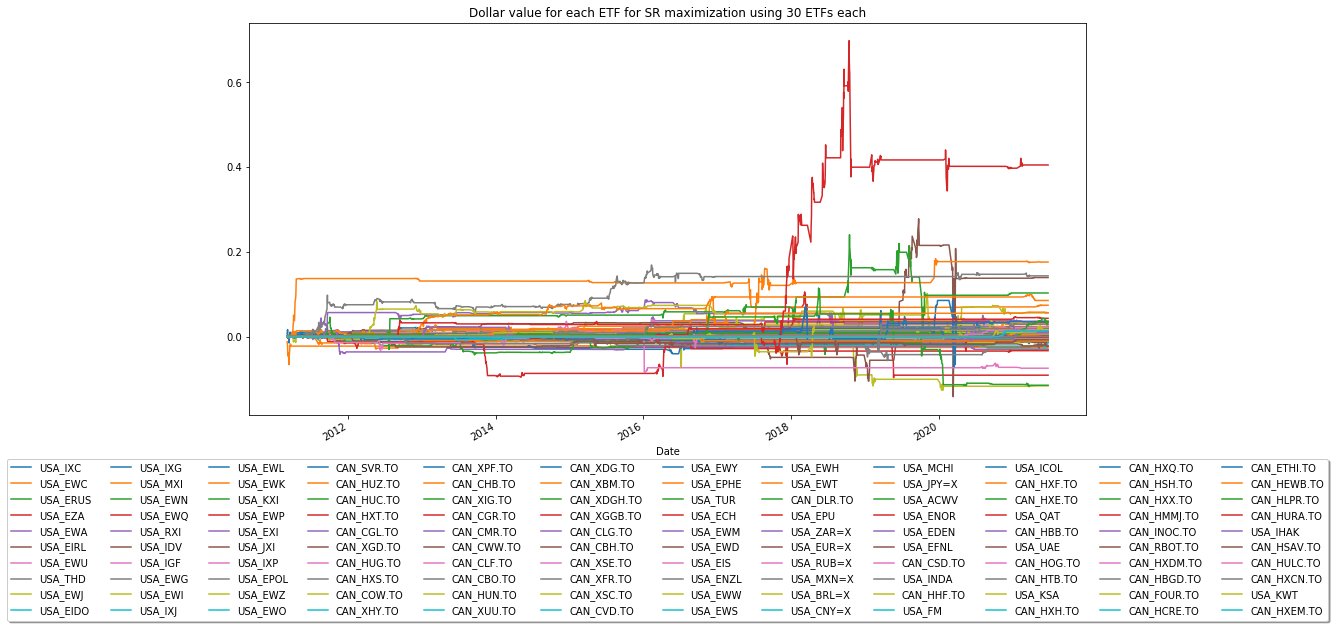

In [388]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/10))
plt.title('Dollar value for each ETF for SR maximization using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 30 ETFs each')

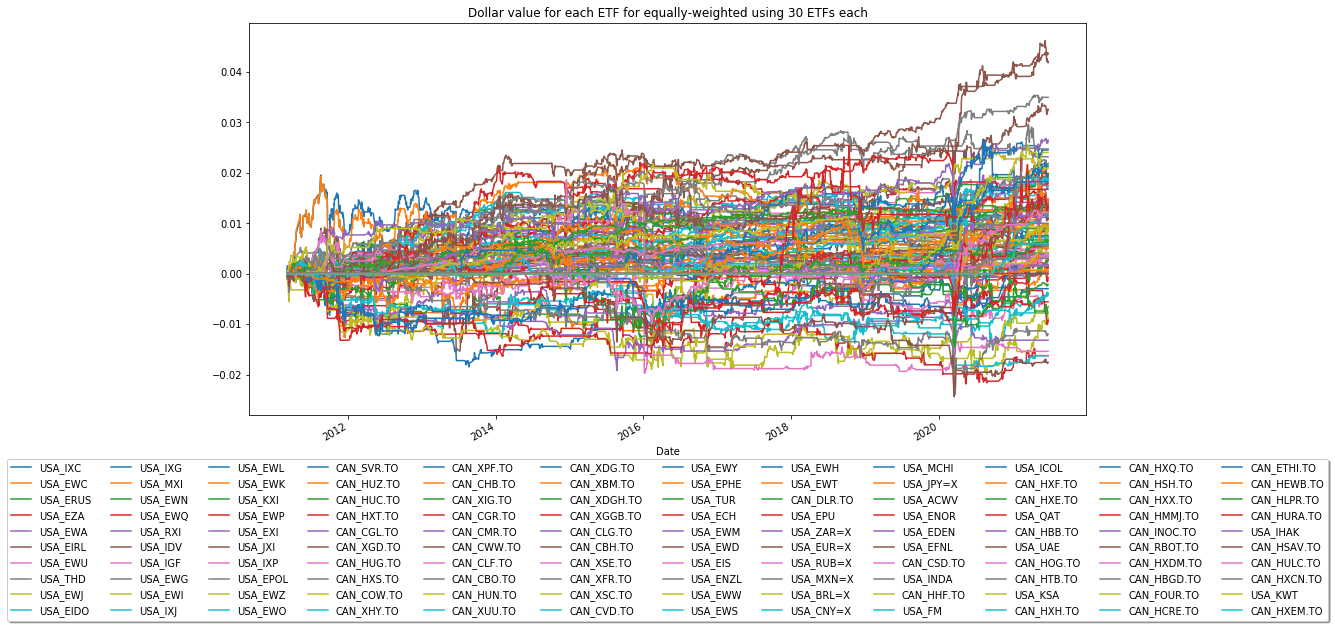

In [389]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/10))
plt.title('Dollar value for each ETF for equally-weighted using 30 ETFs each')

# Scenario Analysis

We will pick time period 2012 January to 2017 December as the scenario testing period, two scenarios will be tested:
1. the entire market will crash by 0.5% with probability 2% in a single day;
2. each ETFs will randomly crash by a half with probability 5% in a single day.

In [402]:
# extract rets from 2020.1 to 2017.12
periodic_rets = {}
for i in range(0,14):
    periodic_rets[i] = semiannual[i]

In [403]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='Market crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Market crash')


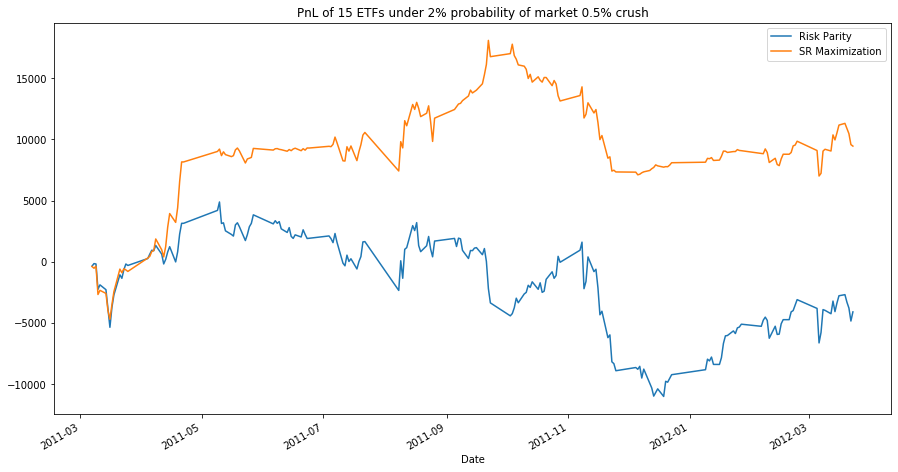

In [404]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 2% probability of market 0.5% crush')
plt.legend()
plt.show()

In [405]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -325.91698685950917%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1852.311520 -2063.090916 -1957.701218 -2063.090916
2       -830.638870 -1504.122250 -1167.380560 -1504.122250
3      -1777.675003 -2954.613401 -2366.144202 -2954.613401
4       -916.162304 -1014.088494  -965.125399 -1014.088494
5      -1082.305372 -1942.145633 -1512.225502 -1942.145633
6      -3399.297034 -4896.484042 -4147.890538 -4896.484042
7      -2008.047697 -2158.243417 -2083.145557 -2158.243417
8       -943.837803 -1639.269386 -1291.553595 -1639.269386
9      -2947.800296 -3731.003690 -3339.401993 -3731.003690
10     -1171.299898 -1238.854960 -1205.077429 -1238.854960
11      -732.877298  -747.408184  -740.142741  -747.408184
12      -805.630382 -2275.803806 -1540.717094 -2275.803806
13     -1304.648299 -2820.794039 -2062.721169 -2820.794039

In [406]:
overallrisk_rp.sum(axis=1)

Period
1     -7936.194571
2     -5006.263930
3    -10053.046007
4     -3909.464691
5     -6478.822140
6    -17340.155655
7     -8407.680088
8     -5513.930169
9    -13749.209670
10    -4854.087246
11    -2967.836406
12    -6897.955088
13    -9008.957547
dtype: float64

In [407]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -79.31086998479459%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1390.790837 -2268.898361 -1829.844599 -2268.898361
2      -1110.824860 -2453.560319 -1782.192589 -2453.560319
3       -755.130544 -1538.743056 -1146.936800 -1538.743056
4       -226.331164  -276.216566  -251.273865  -276.216566
5      -1142.401475 -1605.642614 -1374.022044 -1605.642614
6      -3159.047221 -4107.206141 -3633.126681 -4107.206141
7      -1066.619024 -1667.197719 -1366.908372 -1667.197719
8      -1181.813877 -1539.532826 -1360.673352 -1539.532826
9      -2136.694220 -2583.849911 -2360.272065 -2583.849911
10      -295.271657  -499.445464  -397.358561  -499.445464
11      -256.536652  -405.219991  -330.878322  -405.219991
12      -550.247738  -891.877868  -721.062803  -891.877868
13     -1187.725288 -2135.298159 -1661.511723 -2135.298159

In [413]:
# Individual ETF random crush scenario
opt_sa2 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa2.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='Random ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa2.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Random ETF crash')


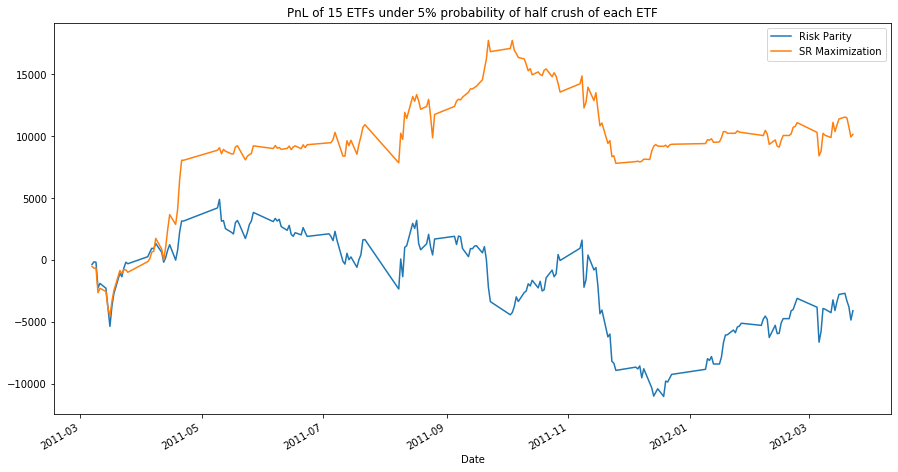

In [414]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of half crush of each ETF')
plt.legend()
plt.show()

In [415]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -325.91684376739374%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1852.311542 -2063.090923 -1957.701232 -2063.090923
2       -830.639017 -1504.122075 -1167.380546 -1504.122075
3      -1777.674997 -2954.613433 -2366.144215 -2954.613433
4       -916.162244 -1014.088350  -965.125297 -1014.088350
5      -1082.304805 -1942.144821 -1512.224813 -1942.144821
6      -3399.296871 -4896.483879 -4147.890375 -4896.483879
7      -2008.046052 -2158.243014 -2083.144533 -2158.243014
8       -943.837768 -1639.269479 -1291.553623 -1639.269479
9      -2947.800352 -3731.004021 -3339.402187 -3731.004021
10     -1171.299534 -1238.854595 -1205.077065 -1238.854595
11      -732.877350  -747.408247  -740.142798  -747.408247
12      -805.630372 -2275.803763 -1540.717068 -2275.803763
13     -1304.648403 -2820.794225 -2062.721314 -2820.794225

In [416]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -99.5725669394579%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
1      -1344.668049 -1977.075530 -1660.871790 -1977.075530
2      -1327.134526 -2546.374723 -1936.754624 -2546.374723
3       -653.647430 -1455.946918 -1054.797174 -1455.946918
4       -342.341734  -544.498735  -443.420234  -544.498735
5      -1090.362677 -1537.415950 -1313.889314 -1537.415950
6      -3043.634283 -3979.022024 -3511.328154 -3979.022024
7       -714.400469 -1254.329381  -984.364925 -1254.329381
8      -1006.677623 -1385.951571 -1196.314597 -1385.951571
9      -1993.592231 -2593.723362 -2293.657796 -2593.723362
10      -303.851013  -547.738456  -425.794734  -547.738456
11      -311.957332  -392.885873  -352.421603  -392.885873
12      -564.166675  -875.061228  -719.613952  -875.061228
13      -866.195663 -1889.973084 -1378.084374 -1889.973084